# The Pawsome Classifier
## Executive Summary

### Background information
#### History of dog pedigrees
"Man's best friend" - a commonly used phrase to describe dogs. Over centuries, dogs have faithfully served as companions to humans by providing assistance to a wide range of activities including hunting, guarding, herding, sport and war. Over the course of history, dogs have been selectively bred based on useful characteristics to optimize their functionality. Therefore, modern day dog pedigrees are a product of such selective breeding, and indirectly reflect the nature of their relationship with humans in the past. Recently, ["designer dogs"](https://www.thesprucepets.com/what-is-a-designer-dog-breed-1118093), where pure-bred dogs are intentionally cross bred to produce offspring with a mixed characteristics of their parents, are becoming a trend.

#### Kennel Clubs
Kennel clubs are organizations that operate nationally to to keep track of dog pedigrees. Additionally, they organize dog shows and competitions. The various kennel clubs also categorize each breed into breed groups based on their general functionality and appearance. It is important to note that each kennel club differs in the methodology used for categorizing dog breeds.

### Problem statement
As an aspiring data scientist new to computer vision, I have planned this project out of personal motivations. Combining my own interest in dogs and machine-learning, I aim to build a model that can categorize dogs by breed. To train the model, I used the Stanford Dogs dataset contains over 20,000 images of 120 different dog breeds. For model evaluation, I included a separate dataset from kaggle with 55 different dog breeds. (The original dataset contained 70 dogs. Only breeds that were in the stanford dataset were used)

#### Summary of Datasets
| Dataset | Source | Purpose | Size | Classes |
|--|--|--|--|--|
| [Stanford Dogs](https://www.kaggle.com/jessicali9530/stanford-dogs-dataset) | Kaggle |Training|20,580|120|
|[55 Dogs](https://www.kaggle.com/gpiosenka/70-dog-breedsimage-data-set)| Kaggle | Evaluation|550|55|
|Designer Dogs|Internet|Prediction|20|10|


#### Modelling approach
The modelling process is split in two stages:
1) Firstly, to reduce the dimensionality of the problem without reducing the amount of images used to train the model, I reclassified the 120 breeds into 12 groupings based on [The Continental Kennel Club's](https://ckcusa.com/) (CKC) breed standards. I selected the CKC's groupings for this project as there is a sufficiently diverse classification system of 12 groups which are based highly on the dog's physical appearance. This should be helpful in training the machine learning model to recognize distinct physical features of various dog breeds.


2) The second stage is to use the above model as a base to train the model to recognize 120 different breeds.

#### Results and evaluation
I used transfer-learning with EfficientNet-B7 as a feature extractor to construct my model. To evaluate the performance of the model, I used a separate dataset containing images of 55 different dog breeds. Additionally, I included some "designer dogs" as a stretch goal to see if the model can accurately predict the dog's heritage. As these "designer dogs" are not recognized as "pure breeds", they are not held by Kennel Club breed standards. It could be interesting to see how the model categorizes such "designer dogs". After fine tuning, the models produced the following results:

| Model | Train Acc |Val Acc|
|--|--|--|
| Dog Group Classifier | 92.0% |82.5%|
|Dog Breed Classifier|79.1%|84.0%|

**Baseline Accuracy for Dog Groups**: 10.26%

**Accuracy on unseen data**: 92.5%

This notebook contains the EDA portion of the project

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import xml.etree.ElementTree as ET
import numpy as np
import random as random
import cv2
import glob
import math
import tensorflow as tf
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15257545015912398387
]


In [3]:
filepath = './data/stanford_dogs/images/Images/'
annotation = './data/stanford_dogs/annotations/Annotation/'
folders = os.listdir(filepath)
annotations = os.listdir(annotation)
breeds=[re.sub('n\d+-','',breed).replace('-','_').lower() for breed in folders]

## Load and preview data

- Dataset includes 2 folders images and annotations
- Images contains 120 directories containing images for each breed
- Annotations contains 120 directories containing the bounding boxes for each breed

In [4]:
#Get images into list
dogs = []
for folder in folders:
    img_list = []
    bbox = []
    for file in os.listdir(annotation + '{}'.format(folder)):
        img=Image.open(filepath + '{}/{}.jpg'.format(folder,file))
        tree=ET.parse(annotation + '{}/{}'.format(folder,file))
        boxes = []
        for box in tree.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            xmax = int(box.find('xmax').text)
            ymin = int(box.find('ymin').text)
            ymax = int(box.find('ymax').text)
            boxes.append([xmin,ymin,xmax,ymax])
        pixels = np.array(img)
        img.close()
        img_list.append(pixels)
        bbox.append(boxes)
    dogs.append([img_list,bbox])

In [5]:
#Function to view images w bounding boxes
def show_img_bbox(data, breed, num):
    get_breed = breeds.index(breed)
    img = data[get_breed][0][num]
    for b in data[get_breed][1][num]:
        xmin = b[0]
        ymin = b[1]
        xmax = b[2]
        ymax = b[3]
        cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,0,0),3);
    return plt.imshow(img);

In [6]:
#continental kennel club groupings
dog_families = {'terrier':['bedlington_terrier','border_terrier','kerry_blue_terrier','irish_terrier',
                          'norfolk_terrier','norwich_terrier','yorkshire_terrier','wire_haired_fox_terrier',
                          'lakeland_terrier','sealyham_terrier','airedale','cairn','australian_terrier',
                          'dandie_dinmont','scotch_terrier','tibetan_terrier','silky_terrier',
                          'soft_coated_wheaten_terrier','west_highland_white_terrier'],
                'pinscher_schnauzer':['miniature_schnauzer','giant_schnauzer','standard_schnauzer','doberman',
                                      'miniature_pinscher','affenpinscher','brabancon_griffon'],
                'companion_toy': ['chihuahua','japanese_spaniel','maltese_dog','pekinese','shih_tzu',
                                  'blenheim_spaniel','papillon','toy_terrier','lhasa','pug','toy_poodle',
                                  'miniature_poodle'],
                'sighthound':['afghan_hound','borzoi','irish_wolfhound','italian_greyhound','whippet',
                             'ibizan_hound','saluki','scottish_deerhound'],
                'scenthound':['rhodesian_ridgeback','basset','beagle','bloodhound','bluetick','black_and_tan_coonhound',
                             'walker_hound','english_foxhound','redbone','otterhound'],
               'gundog':['weimaraner','flat_coated_retriever','curly_coated_retriever','golden_retriever',
                         'labrador_retriever','chesapeake_bay_retriever','german_short_haired_pointer',
                         'vizsla', 'english_setter','irish_setter','gordon_setter','brittany_spaniel',
                         'clumber', 'english_springer','welsh_springer_spaniel','cocker_spaniel',
                         'sussex_spaniel', 'irish_water_spaniel','standard_poodle'],
                'primal':['basenji','mexican_hairless','dingo','dhole','african_hunting_dog'],
                'spitz_nordic': ['norwegian_elkhound','eskimo_dog','siberian_husky','malamute','samoyed',
                                'pomeranian','chow','keeshond'],
                'pastoral_stock':['schipperke','groenendael','malinois','briard','kelpie','old_english_sheepdog',
                                  'shetland_sheepdog','collie','border_collie','bouvier_des_flandres','german_shepherd',
                                  'pembroke','cardigan','komondor'],
                'guardian_pastoral_mountain':['kuvasz','greater_swiss_mountain_dog','bernese_mountain_dog','appenzeller',
                                              'entlebucher','tibetan_mastiff','saint_bernard','leonberg','newfoundland',
                                              'great_pyrenees'],
                'mastiff':['rottweiler','boxer','bull_mastiff','great_dane'],
                'bull':['staffordshire_bullterrier','american_staffordshire_terrier','boston_bull','french_bulldog'],
                }

Let's view some examples of dog breeds for each new category based on the Continental Kennel Club breed standards.

### Terrier
[Terrier dogs](http://www.animalplanet.com/breed-selector/dog-breeds/terrier-dogs.html) (from french word *terrier* meaning 'burrow' which comes from latin word *terra* which means 'earth')
- Function : Originally bred to dig/flush out and hunt for vermin such as foxes, moles, badgers and rats.

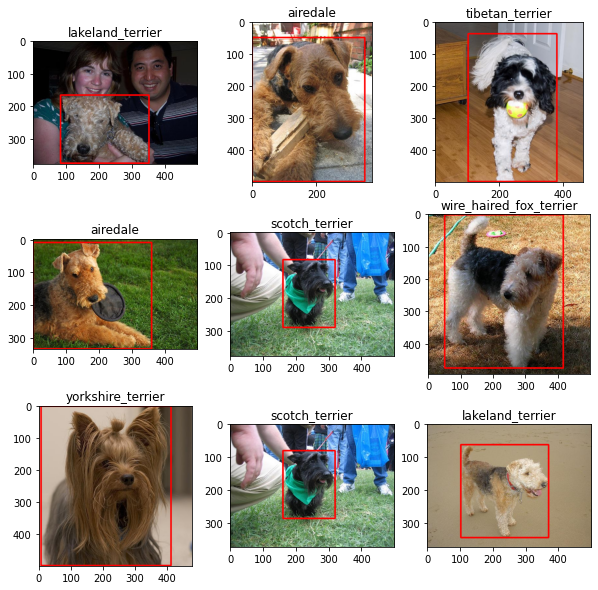

In [96]:
#Show terrier
plt.figure(figsize=(10, 10))
for i in range(9):
    dog_breed = random.choice(dog_families['terrier'])
    n = random.randint(0,25)
    ax = plt.subplot(3, 3, i + 1)
    show_img_bbox(data = dogs,
                 breed = dog_breed,
                 num = n)
    plt.title(label = dog_breed)

### Pinschers and schnauzers
Though they may look different, they share common ancestry with the German Pinscher, which is the oldest of pinscher breeds.

[Pinschers](https://germanpinscher.org/about/): from french word *pincer* meaning 'to seize/nip'
- Function: originally bred to hunt rats in farms, fighting and guarding

[Schnauzers](https://www.thekennelclub.org.uk/breed-standards/utility/schnauzer/): from german word for "snout" to highlight the characteristic moustache that these dogs have. These dogs also have feathery eyebrows.
- Function: multifunctional (catch rodents, guard dogs, message carriers in times of war, police dogs)

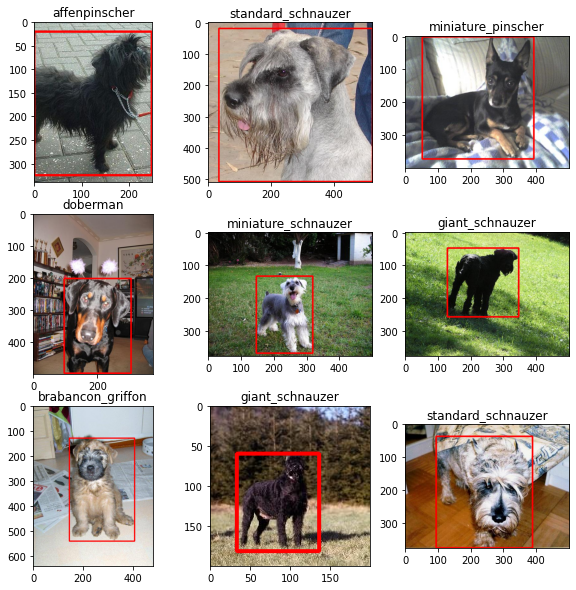

In [97]:
#Show pinscher_schnauzer
plt.figure(figsize=(10, 10))
for i in range(9):
    dog_breed = random.choice(dog_families['pinscher_schnauzer'])
    n = random.randint(0,25)
    ax = plt.subplot(3, 3, i + 1)
    show_img_bbox(data = dogs,
                 breed = dog_breed,
                 num = n)
    plt.title(label = dog_breed)

### Companion and toy

Companion and toy dogs are a result of miniaturisation of existing breeds.
- Function: small and light enough to be carried around by owners

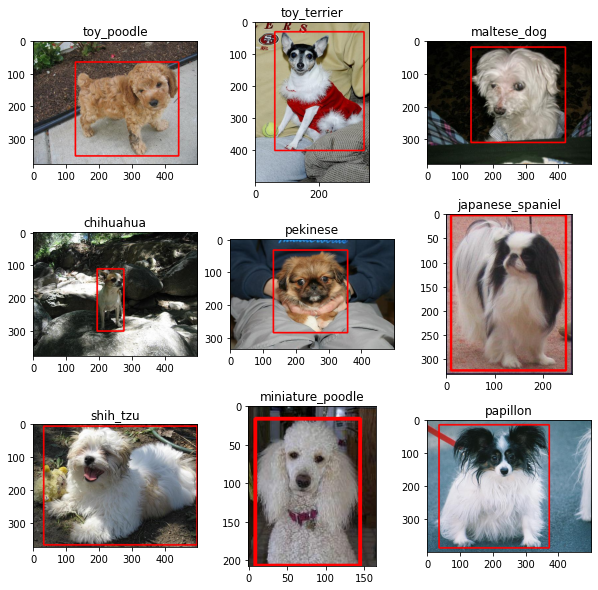

In [15]:
#Show companion_toy
plt.figure(figsize=(10, 10))
for i in range(9):
    dog_breed = random.choice(dog_families['companion_toy'])
    n = random.randint(0,25)
    ax = plt.subplot(3, 3, i + 1)
    show_img_bbox(data = dogs,
                 breed = dog_breed,
                 num = n)
    plt.title(label = dog_breed)

### Sighthounds

[Sighthounds](https://www.akc.org/expert-advice/health/the-skinny-on-sighthounds/) are hunting dogs that hunt by sight and speed.
- Function: Specialize in pursuing prey and keeping them in sight. Prey includes quick animals such as deer, hares, wolves.
- Longer-legged to chase prey and deep ribcage for large lungs and heart for anaerobic and aerobic spriting.
- Lean bodied to minimize weight, lean head for wider field of vision but reduced depth perception.

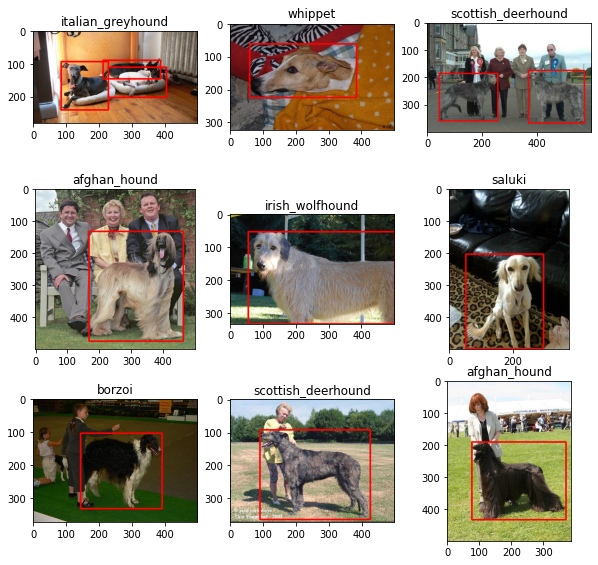

In [16]:
#Show sighthound
plt.figure(figsize=(10, 10))
for i in range(9):
    dog_breed = random.choice(dog_families['sighthound'])
    n = random.randint(0,25)
    ax = plt.subplot(3, 3, i + 1)
    show_img_bbox(data = dogs,
                 breed = dog_breed,
                 num = n)
    plt.title(label = dog_breed)

### Scenthound

Scenthounds hunt primarily on scent and endurance.
- Function: Specialize in following scent trails.
- Long drooping ears and large nasal cavities to enhance smell sensitivity

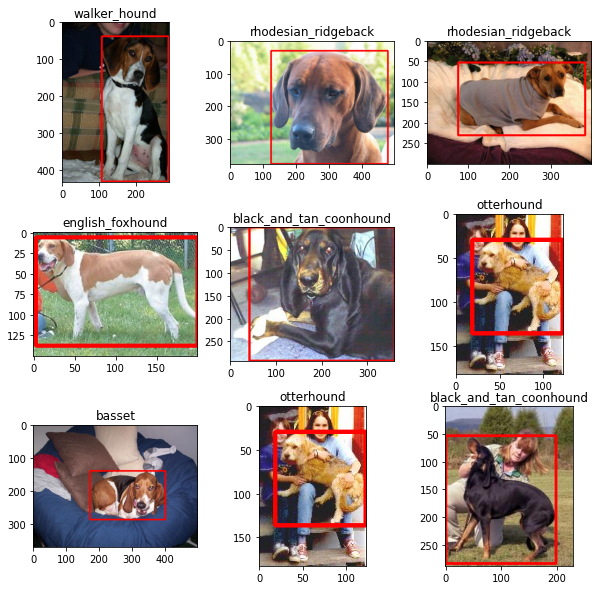

In [73]:
#Show scenthound
plt.figure(figsize=(10, 10))
for i in range(9):
    dog_breed = random.choice(dog_families['scenthound'])
    n = random.randint(0,25)
    ax = plt.subplot(3, 3, i + 1)
    show_img_bbox(data = dogs,
                 breed = dog_breed,
                 num = n)
    plt.title(label = dog_breed)

### Gundog

- Function: Gundogs were primarily used for hunting birds even before the invention of firearms.
Subdivisions within this category include retrievers, pointers, setters and spaniels.

- Retrievers are water dogs.

- Pointers were bred to identify bird locations with distinctive "pointing" stance

- Setters tend to crouch (set) upon locating game

- Spaniels are descent from setters but with the added ability to flush out prey.

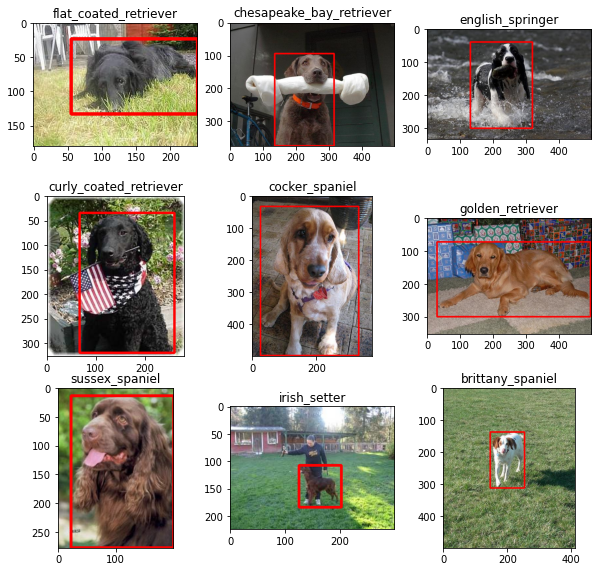

In [70]:
#Show gundog
plt.figure(figsize=(10, 10))
for i in range(9):
    dog_breed = random.choice(dog_families['gundog'])
    n = random.randint(0,25)
    ax = plt.subplot(3, 3, i + 1)
    show_img_bbox(data = dogs,
                 breed = dog_breed,
                 num = n)
    plt.title(label = dog_breed)

### Primal

Primal breeds are extremely old, primitive breeds that stem from ancient times. These breeds are considered as pariah, or like outliers amongst the domestic dog breeds.

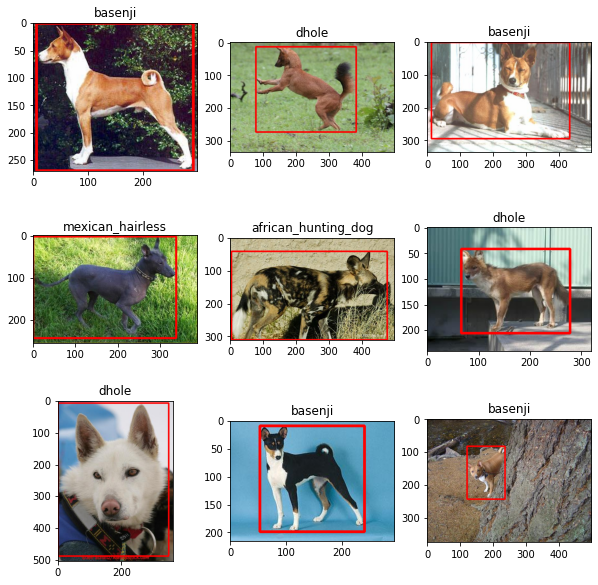

In [88]:
#Show primal
plt.figure(figsize=(10, 10))
for i in range(9):
    dog_breed = random.choice(dog_families['primal'])
    n = random.randint(0,25)
    ax = plt.subplot(3, 3, i + 1)
    show_img_bbox(data = dogs,
                 breed = dog_breed,
                 num = n)
    plt.title(label = dog_breed)

### Spitz nordic

[Spitz/nordic](https://www.ukcdogs.com/breed-groups) species contains arctic dogs that were essential in the survival of arctic people. They are mostly descent from wolves and have thick, insulating coats. Spitz breeds also have tails that distinctly curl over the dog's back.

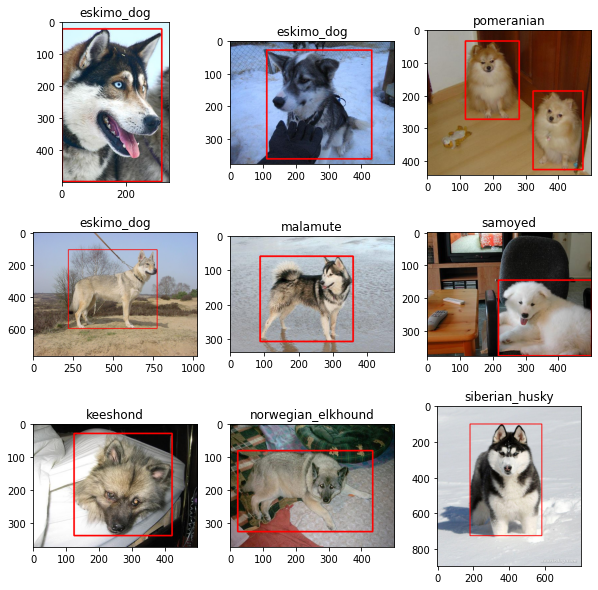

In [20]:
#Show spitz_nordic
plt.figure(figsize=(10, 10))
for i in range(9):
    dog_breed = random.choice(dog_families['spitz_nordic'])
    n = random.randint(0,25)
    ax = plt.subplot(3, 3, i + 1)
    show_img_bbox(data = dogs,
                 breed = dog_breed,
                 num = n)
    plt.title(label = dog_breed)

### Pastoral Stock
The word "pastoral" implies grazing livestock. 
- Function: Dogs in the [pastoral/stock](https://www.dogzone.com/breeds/groups/pastoral-dogs/) category were used on the farm to help with maintaining and herding livestock.
- They need to be large enough to drive off predators, have abundant stamina to run with the herd, and be intelligent enough to work cooperatively with the farmer.

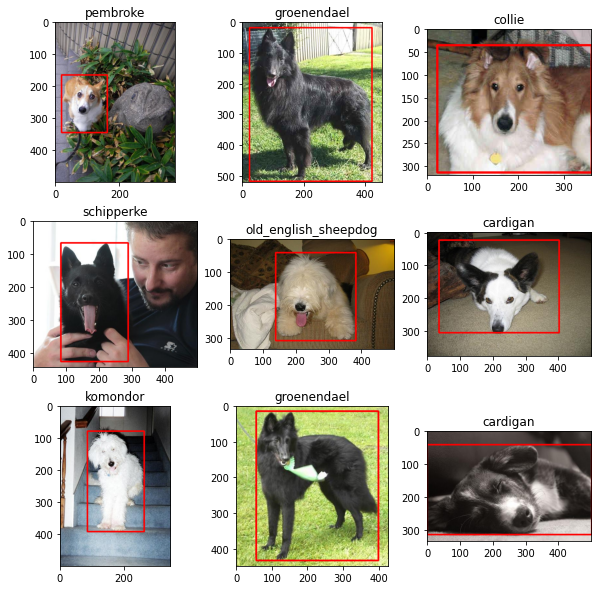

In [21]:
#Show pastoral stock
plt.figure(figsize=(10, 10))
for i in range(9):
    dog_breed = random.choice(dog_families['pastoral_stock'])
    n = random.randint(0,25)
    ax = plt.subplot(3, 3, i + 1)
    show_img_bbox(data = dogs,
                 breed = dog_breed,
                 num = n)
    plt.title(label = dog_breed)

### Guardian pastoral mountain

Guardian pastoral dogs are dogs which watch over livestock by integrating with the herd. Mountain dogs are dogs which were used historically by people living in mountainous regions for various working purposes such as farming or even pulling carts. They tend to be built large and can endure tough terrain.

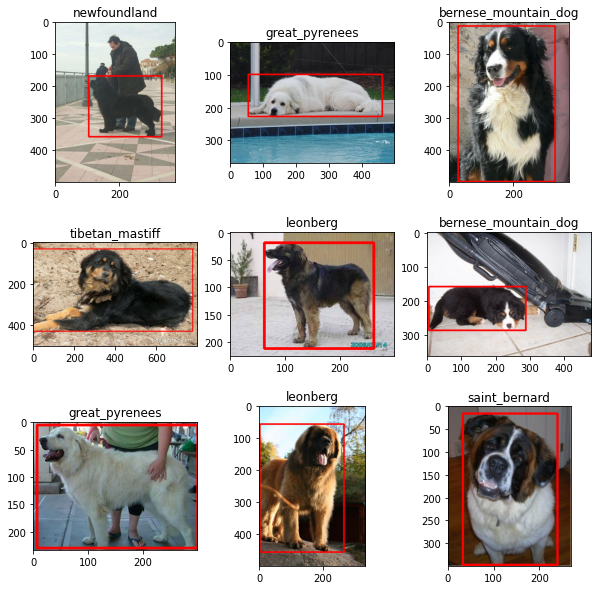

In [22]:
#Show guardian_pastoral_mountain
plt.figure(figsize=(10, 10))
for i in range(9):
    dog_breed = random.choice(dog_families['guardian_pastoral_mountain'])
    n = random.randint(0,25)
    ax = plt.subplot(3, 3, i + 1)
    show_img_bbox(data = dogs,
                 breed = dog_breed,
                 num = n)
    plt.title(label = dog_breed)

#### Mastiff

[Mastiffs](https://dogtime.com/dog-breeds/mastiff) are considered one oof the most ancient types of dogs. Ancestors from this dog group were used as fierce war dogs or for blood sports. Therefore modern day mastiffs tend to be large, muscular and aggressive.

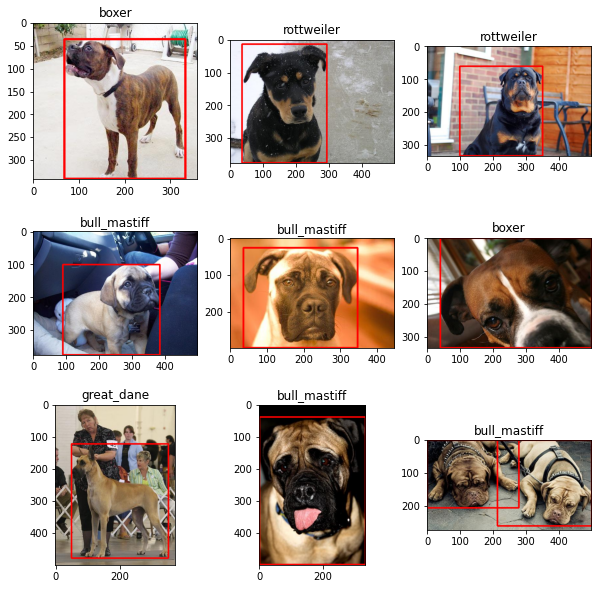

In [74]:
#Show mastiff
plt.figure(figsize=(10, 10))
for i in range(9):
    dog_breed = random.choice(dog_families['mastiff'])
    n = random.randint(0,25)
    ax = plt.subplot(3, 3, i + 1)
    show_img_bbox(data = dogs,
                 breed = dog_breed,
                 num = n)
    plt.title(label = dog_breed)

### Bull

Originally used for the sport of bull-baiting. Includes bullterriers which are crosses between bulldog and terrier species.

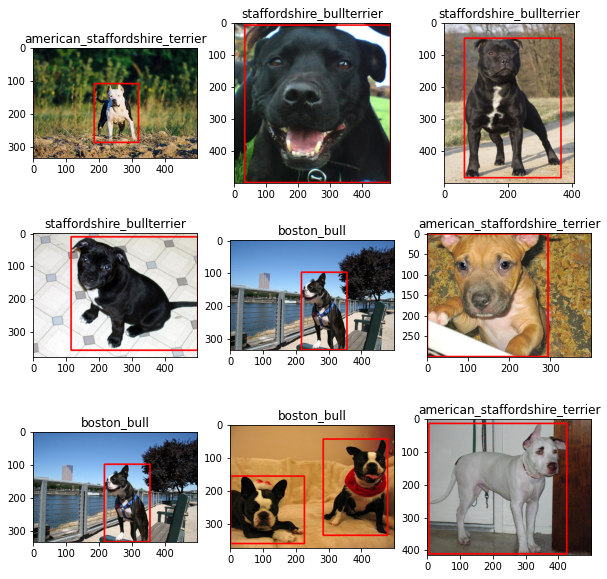

In [24]:
#Show bull
plt.figure(figsize=(10, 10))
for i in range(9):
    dog_breed = random.choice(dog_families['bull'])
    n = random.randint(0,25)
    ax = plt.subplot(3, 3, i + 1)
    show_img_bbox(data = dogs,
                 breed = dog_breed,
                 num = n)
    plt.title(label = dog_breed)

## Cropping Images

As seen above, the images sometimes do not have the dog in focus. In some cases, there are multiple dogs in the same image. This may lead to noisy data when constructing a model to classify dogs. To overcome this, I cropped the images using the bounding boxes provided in the annotations then saved the cropped image in a new directory.

In [ ]:
#Crop images and save cropped images
box_number = ['','a','b','c','d','e']


for folder in folders:
    breed = re.sub('n\d+-','',folder).replace('-','_').lower()
    for file in os.listdir(annotation + '{}'.format(folder)):
        img=image.load_img(filepath + '{}/{}.jpg'.format(folder,file))
        tree=ET.parse(annotation + '{}/{}'.format(folder,file))
        num = 0
        for box in tree.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            xmax = int(box.find('xmax').text)
            ymin = int(box.find('ymin').text)
            ymax = int(box.find('ymax').text)
            if xmax > img.size[0]:
                width = img.size[0] - xmin
            else:
                width = xmax - xmin
            
            if ymax > img.size[1]:
                height = img.size[1] - ymin
            else:
                height = ymax - ymin
            
            cropped_img = tf.image.crop_to_bounding_box(image = img,
                                              offset_height = ymin,
                                              offset_width = xmin,
                                              target_height = height,
                                              target_width = width)
            for k in dog_families.keys():
                if breed in dog_families[k]:
                    output_image = tf.image.encode_png(cropped_img)
                    file_name = tf.constant('./data/stanford_dogs/cropped_images/dog_families/' + k + '/' + file + box_number[num] + '.png')
                    output = tf.io.write_file(file_name, output_image)
            num+=1
        img.close()

## Reclassification of dog breeds

In this section we load and preview the cropped images according to the newly defined classes.

In [7]:
family_filepath = './data/stanford_dogs/cropped_images/dog_families/'
family_folders = os.listdir(family_filepath)

In [8]:
family_folders

['bull',
 'companion_toy',
 'guardian_pastoral_mountain',
 'gundog',
 'mastiff',
 'pastoral_stock',
 'pinscher_schnauzer',
 'primal',
 'scenthound',
 'sighthound',
 'spitz_nordic',
 'terrier']

In [9]:
def get_filepaths(category):
    locals()[category] = []
    locals()[category] += glob.glob(family_filepath + category + '/*.png')
    return locals()[category]

In [37]:
companion_toy = get_filepaths('companion_toy')
scenthound = get_filepaths('scenthound')
sighthound = get_filepaths('sighthound')
spitz_nordic = get_filepaths('spitz_nordic')
gundog = get_filepaths('gundog')
bull = get_filepaths('bull')
terrier = get_filepaths('terrier')
guardian_pastoral_mountain = get_filepaths('guardian_pastoral_mountain')
pastoral_stock = get_filepaths('pastoral_stock')
mastiff = get_filepaths('mastiff')
pinscher_schnauzer = get_filepaths('pinscher_schnauzer')
primal = get_filepaths('primal')

classes = list(dog_families.keys())

In [38]:
df1 = pd.DataFrame(terrier, columns = ["filename"])
df2 = pd.DataFrame(pinscher_schnauzer, columns = ["filename"])
df3 = pd.DataFrame(companion_toy, columns = ["filename"])
df4 = pd.DataFrame(sighthound, columns = ["filename"])
df5 = pd.DataFrame(scenthound, columns = ["filename"])
df6 = pd.DataFrame(gundog, columns = ["filename"])
df7 = pd.DataFrame(primal, columns = ["filename"])
df8 = pd.DataFrame(spitz_nordic, columns = ["filename"])
df9 = pd.DataFrame(pastoral_stock, columns = ["filename"])
df10 = pd.DataFrame(bull, columns = ["filename"])
df11 = pd.DataFrame(mastiff, columns = ["filename"])
df12 = pd.DataFrame(guardian_pastoral_mountain, columns = ["filename"])

In [39]:
df1['class'] = pd.Series(['0' for x in range(len(df1.index))], index=df1.index)
df2['class'] = pd.Series(['1' for x in range(len(df2.index))], index=df2.index)
df3['class'] = pd.Series(['2' for x in range(len(df3.index))], index=df3.index)
df4['class'] = pd.Series(['3' for x in range(len(df4.index))], index=df4.index)
df5['class'] = pd.Series(['4' for x in range(len(df5.index))], index=df5.index)
df6['class']  = pd.Series(['5' for x in range(len(df6.index))], index=df6.index)
df7['class']  = pd.Series(['6' for x in range(len(df7.index))], index=df7.index)
df8['class']  = pd.Series(['7' for x in range(len(df8.index))], index=df8.index)
df9['class']  = pd.Series(['8' for x in range(len(df9.index))], index=df9.index)
df10['class']  = pd.Series(['9' for x in range(len(df10.index))], index=df10.index)
df11['class']  = pd.Series(['10' for x in range(len(df11.index))], index=df11.index)
df12['class']  = pd.Series(['11' for x in range(len(df12.index))], index=df12.index)

In [40]:
dog_families_df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12])

In [41]:
dog_families_df.shape

(22126, 2)

In [42]:
#shuffle
dog_families_df = dog_families_df.sample(frac=1).reset_index(drop=True)

In [43]:
dog_families_df

filename class
0      ./data/stanford_dogs/cropped_images/dog_famili...     0
1      ./data/stanford_dogs/cropped_images/dog_famili...     0
2      ./data/stanford_dogs/cropped_images/dog_famili...     3
3      ./data/stanford_dogs/cropped_images/dog_famili...    11
4      ./data/stanford_dogs/cropped_images/dog_famili...     2
...                                                  ...   ...
22121  ./data/stanford_dogs/cropped_images/dog_famili...    10
22122  ./data/stanford_dogs/cropped_images/dog_famili...     3
22123  ./data/stanford_dogs/cropped_images/dog_famili...     9
22124  ./data/stanford_dogs/cropped_images/dog_famili...     5
22125  ./data/stanford_dogs/cropped_images/dog_famili...     2

[22126 rows x 2 columns]

In [44]:
classes

['terrier',
 'pinscher_schnauzer',
 'companion_toy',
 'sighthound',
 'scenthound',
 'gundog',
 'primal',
 'spitz_nordic',
 'pastoral_stock',
 'guardian_pastoral_mountain',
 'mastiff',
 'bull']

0     0.164784
5     0.141508
2     0.105577
8     0.104176
11    0.089985
3     0.083024
4     0.080494
7     0.073714
1     0.052924
6     0.043297
9     0.031230
10    0.029287
Name: class, dtype: float64


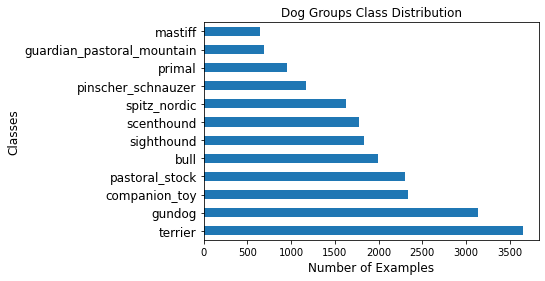

In [65]:
print(dog_families_df['class'].value_counts(normalize = True))


ax = dog_families_df['class'].value_counts().plot.barh()
ax.set_xlabel("Number of Examples", fontsize=12)
ax.set_ylabel("Classes", fontsize=12)
ax.set_yticklabels([classes[0],classes[5],classes[2],classes[8],classes[11],classes[3],classes[4],classes[7],classes[1],classes[6],classes[9],classes[10]], rotation=0, fontsize=12)
ax.set_title('Dog Groups Class Distribution')
plt.show()

We observe that there is an uneven distribution of classes. 

There are a large number of images for terriers and gun dogs. This is likely due to the fact that several independent breeds within the stanford dogs dataset belong to these groups.

On the other hand, there are limited images for mastiffs, guardian_pastoral_mountain, primal, and pinscher_schnauzers. Similarly there are much fewer dog species in the original dataset that fit into these groupings.

### Baseline Accuracy

The baseline accuracy can be computed using random rate classification

In [58]:
baseline = 0
for i in list(dog_families_df['class'].value_counts(normalize = True)):
    baseline += i**2
print(f'Baseline Accuracy is {round(baseline*100,2)}%')

Baseline Accuracy is 10.26%


## Image Augmentation

During the modelling process, the images will be loaded using ImageDataGenerator, which can perform augmentations to the training data such as randomly rotating or flipping the images. This helps to generate more training data from the original dataset and helps to reduce overfitting in the model.

In this section, we preview examples of the type of augmentation used for the modelling process.

In [46]:
batch = 128

In [47]:
#Set the augmentations to be applied during the modelling process
#Random rotation: 40 degrees
#Width/height shift: 10%
#Random horizontal flips

augment = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.1,  
                             height_shift_range=0.1, 
                             horizontal_flip=True,  
                             vertical_flip=False,
                             validation_split = 0.2,
                            )
no_augment = ImageDataGenerator()

In [59]:
augmented_images = augment.flow_from_dataframe(dog_families_df,
                                                  batch_size = batch,
                                                  seed = 25,
                                                  shuffle = False)

Found 22126 validated image filenames belonging to 12 classes.


In [60]:
classes = list(dog_families.keys())
classes

['terrier',
 'pinscher_schnauzer',
 'companion_toy',
 'sighthound',
 'scenthound',
 'gundog',
 'primal',
 'spitz_nordic',
 'pastoral_stock',
 'guardian_pastoral_mountain',
 'mastiff',
 'bull']

In [61]:
class_labels = list(augmented_images.class_indices.keys())
class_labels

['0', '1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9']

Found 22126 validated image filenames belonging to 12 classes.


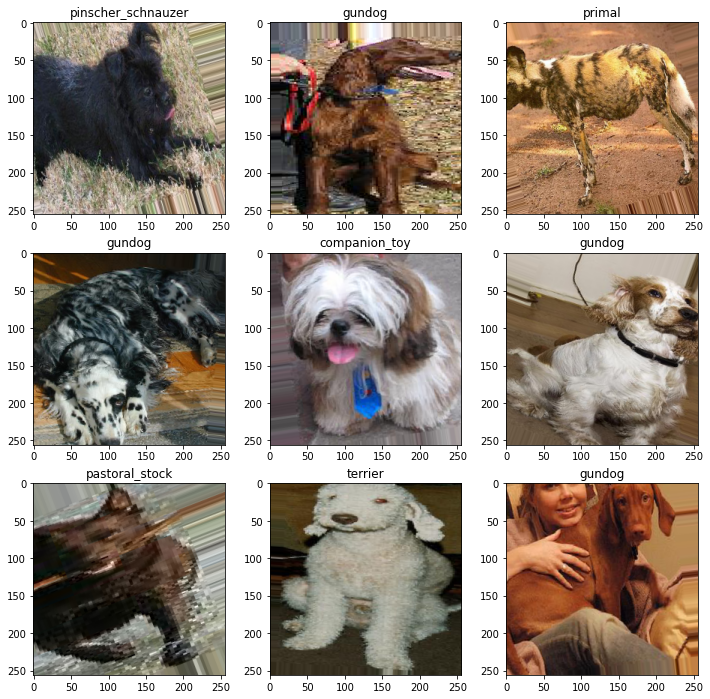

In [64]:
for X_batch, y_batch in augment.flow_from_dataframe(dog_families_df,
                                                    batch_size= batch,
                                                   seed = 25):
# create a grid of 3x3 images
    plt.figure(figsize=(12, 12))
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i]/255)
        plt.title(classes[int(class_labels[y_batch[i].argmax(axis = -1)])])
        #show the plot
    plt.show()
    break